In [1]:
# EXTERNAL LIBRARY IMPORTS
import numpy as np 
import scipy 

import torch # Need torch version 0.3 or 0.4
import torch.nn as nn 
import torch.optim as optim 
assert torch.__version__[:3] in ['0.3', '0.4']

# use_gpu = torch.cuda.is_available()
# print(use_gpu)

use_gpu = False

# MISTER ED SPECIFIC IMPORT BLOCK
# (here we do things so relative imports work )
# Universal import block 
# Block to get the relative imports working 

import os, sys, re
# module_path = os.path.abspath(os.path.join('..'))
# if module_path not in sys.path:
#     sys.path.append(module_path)
import config
import prebuilt_loss_functions as plf
import loss_functions as lf 
import utils.pytorch_utils as utils
import utils.image_utils as img_utils
import cifar10.cifar_loader as cifar_loader
import cifar10.cifar_resnets as cifar_resnets
import adversarial_attacks as aa
import adversarial_training as advtrain
import adversarial_evaluation as adveval
import utils.checkpoints as checkpoints
import adversarial_perturbations as ap 
import adversarial_attacks_refactor as aar
import spatial_transformers as st

### START pytorch_image_classification imports
import time, random, json, logging, argparse, csv
# import numpy as np
# import torch.optim
# import torch.utils.data
# import torch.backends.cudnn
# import torchvision.utils
from pytorch_image_classification_dataloader_c10h import get_loader
from pytorch_image_classification_utils import (str2bool, load_model, save_checkpoint, create_optimizer,
                                                AverageMeter, mixup, CrossEntropyLoss, onehot)
# from rutils_run import save_checkpoint_epoch
from pytorch_image_classification_argparser import get_config

/home/joshuacp/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.
/home/joshuacp/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
sys.argv = ['']

def parse_args():
    parser = argparse.ArgumentParser()
    parser.add_argument('--arch', type=str, default='resnet')
    parser.add_argument('--config', type=str, default='tmp_reference_model/resnet_basic_110_config.json')
    # model config (VGG)
    parser.add_argument('--n_channels', type=str)
    parser.add_argument('--n_layers', type=str)
    parser.add_argument('--use_bn', type=str2bool)
    #
    parser.add_argument('--base_channels', type=int)
    parser.add_argument('--block_type', type=str)
    parser.add_argument('--depth', type=int)
    # model config (ResNet-preact)
    parser.add_argument('--remove_first_relu', type=str2bool)
    parser.add_argument('--add_last_bn', type=str2bool)
    parser.add_argument('--preact_stage', type=str)
    # model config (WRN)
    parser.add_argument('--widening_factor', type=int)
    # model config (DenseNet)
    parser.add_argument('--growth_rate', type=int)
    parser.add_argument('--compression_rate', type=float)
    # model config (WRN, DenseNet)
    parser.add_argument('--drop_rate', type=float)
    # model config (PyramidNet)
    parser.add_argument('--pyramid_alpha', type=int)
    # model config (ResNeXt)
    parser.add_argument('--cardinality', type=int)
    # model config (shake-shake)
    parser.add_argument('--shake_forward', type=str2bool)
    parser.add_argument('--shake_backward', type=str2bool)
    parser.add_argument('--shake_image', type=str2bool)
    # model config (SENet)
    parser.add_argument('--se_reduction', type=int)

    parser.add_argument('--outdir', type=str, required=False)
    parser.add_argument('--seed', type=int, default=17)
    parser.add_argument('--test_first', type=str2bool, default=True)
    parser.add_argument('--gpu', type=str, default='0') # -1 for CPU
    # TensorBoard configuration
    parser.add_argument(
        '--tensorboard', dest='tensorboard', action='store_true', default=True)
    parser.add_argument(
        '--no-tensorboard', dest='tensorboard', action='store_false')
    parser.add_argument('--tensorboard_train_images', action='store_true')
    parser.add_argument('--tensorboard_test_images', action='store_true')
    parser.add_argument('--tensorboard_model_params', action='store_true')
    # configuration of optimizer
    parser.add_argument('--epochs', type=int)
    parser.add_argument('--batch_size', type=int)
    parser.add_argument('--optimizer', type=str, choices=['sgd', 'adam'])
    parser.add_argument('--base_lr', type=float)
    parser.add_argument('--weight_decay', type=float)
    # configuration for SGD
    parser.add_argument('--momentum', type=float)
    parser.add_argument('--nesterov', type=str2bool)
    # configuration for learning rate scheduler
    parser.add_argument(
        '--scheduler', type=str, choices=['none', 'multistep', 'cosine'])
    # configuration for multi-step scheduler]
    parser.add_argument('--milestones', type=str)
    parser.add_argument('--lr_decay', type=float)
    # configuration for cosine-annealing scheduler]
    parser.add_argument('--lr_min', type=float, default=0)
    # configuration for Adam
    parser.add_argument('--betas', type=str)
    # configuration of data loader
    parser.add_argument(
        '--dataset',
        type=str,
        default='CIFAR10',
        choices=['CIFAR10', 'CIFAR10H'])
    parser.add_argument('--num_workers', type=int, default=7)
    # cutout configuration
    parser.add_argument('--use_cutout', action='store_true', default=False)
    parser.add_argument('--cutout_size', type=int, default=16)
    parser.add_argument('--cutout_prob', type=float, default=1)
    parser.add_argument('--cutout_inside', action='store_true', default=False)
    # random erasing configuration
    parser.add_argument(
        '--use_random_erasing', action='store_true', default=False)
    parser.add_argument('--random_erasing_prob', type=float, default=0.5)
    parser.add_argument(
        '--random_erasing_area_ratio_range', type=str, default='[0.02, 0.4]')
    parser.add_argument(
        '--random_erasing_min_aspect_ratio', type=float, default=0.3)
    parser.add_argument('--random_erasing_max_attempt', type=int, default=20)
    # mixup configuration
    parser.add_argument('--use_mixup', action='store_true', default=False)
    parser.add_argument('--mixup_alpha', type=float, default=1)

    # previous model weights to load if any
    parser.add_argument('--resume', type=str)
    # whether to tune to human labels
    parser.add_argument('--human_tune', action='store_true', default=False)
    # where to save the loss/accuracy for c10h to a csv file
    parser.add_argument('--c10h_scores_outdir', type=str, default='tmp')
    # c10h scores save interval (in epochs)
    parser.add_argument('--c10h_save_interval', type=str, default='1') # changed from int
    # how much of the data to use use for test for c10h training
    parser.add_argument('--c10h_testsplit_percent', type=float, default=0.1)
    # seed for splitting the c10h data into train/test
    parser.add_argument('--c10h_datasplit_seed', type=int, default=999)
    # whether to use the cifar10 labels for the human test set (CONTROL)
    parser.add_argument('--nonhuman_control', type=str2bool, default=False)
    # whether to sample from the human labels to get one-hot samples
    parser.add_argument('--c10h_sample', action='store_true', default=False)
    # whether to save to out_dir
    parser.add_argument('--no_output', action='store_true', default=False)
    # to test the loaded model and don't train
    parser.add_argument('--test_only', action='store_true', default=False)

    args = parser.parse_args()
    # if not is_tensorboard_available:
    args.tensorboard = False

    config = get_config(args)

    return config

config = parse_args()

run_config = config['run_config']


def load_our_model(config, weights_path):
        
    our_model = load_model(config['model_config'])
    
    # load pretrained weights if given
    if os.path.isfile(weights_path):
        print("=> loading checkpoint '{}'".format(weights_path))

        # Resolve CPU/GPU stuff
        if use_gpu:
            map_location = None
        else:
            map_location= (lambda s, l: s)

        checkpoint = torch.load(weights_path,
                                map_location=map_location)

        correct_state_dict = {re.sub(r'^module\.', '', k): v for k, v in
                              checkpoint['state_dict'].items()}

        our_model.load_state_dict(correct_state_dict)

        print("=> loaded checkpoint '{}' (epoch {})"
              .format(weights_path, checkpoint['epoch']))
    else:
        print("=> no checkpoint found at '{}'".format(weights_path))
        
    return our_model

# model = load_our_model(config, run_config['resume'])

cifar_valset = cifar_loader.load_cifar_data('val', batch_size=32)

_, normalizer = cifar_loader.load_pretrained_cifar_resnet(flavor=32, use_gpu=use_gpu,
                                                          return_normalizer=True)

run_config['resume'] = 'tmp_reference_model/model_state_resnet_basic_110_con_True_lr_001_seed_0.pth'
#run_config['resume'] = 'tmp_reference_model/model_best_state.pth'
model_gt = load_our_model(config, run_config['resume'])

run_config['resume'] = 'tmp_reference_model/model_state_resnet_basic_110_con_False_lr_001_seed_0.pth'
model_human = load_our_model(config, run_config['resume'])

if use_gpu:
    examples = examples.cuda()
    labels = labels.cuda() 
    model_gt.cuda()
    model_human.cuda()
    
models = [model_gt, model_human]

Files already downloaded and verified
=> loading checkpoint 'tmp_reference_model/model_state_resnet_basic_110_con_True_lr_001_seed_0.pth'
=> loaded checkpoint 'tmp_reference_model/model_state_resnet_basic_110_con_True_lr_001_seed_0.pth' (epoch 100)
=> loading checkpoint 'tmp_reference_model/model_state_resnet_basic_110_con_False_lr_001_seed_0.pth'
=> loaded checkpoint 'tmp_reference_model/model_state_resnet_basic_110_con_False_lr_001_seed_0.pth' (epoch 100)


Files already downloaded and verified
(Pre FGSM):  99.0 correct
(Post FGSM):  23.0 correct
tensor(0.1201, grad_fn=<MulBackward>) tensor(6.9834, grad_fn=<MulBackward>) [tensor(99.)]


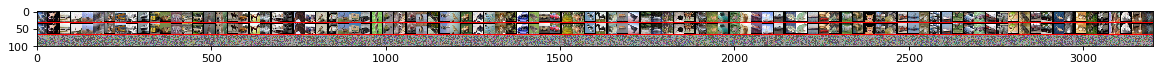

(Pre FGSM):  97.0 correct
(Post FGSM):  11.0 correct
tensor(0.1352, grad_fn=<MulBackward>) tensor(4.0510, grad_fn=<MulBackward>) [tensor(97.)]


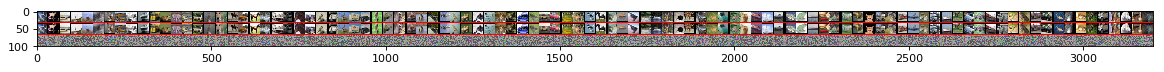

In [10]:
cifar_valset = cifar_loader.load_cifar_data('val', batch_size=100)
examples, labels = next(iter(cifar_valset))

'''
Everything is in [0,1] range, so lp_bound of 8 pixels is 8.0 / 255!
Any perturbation object generated from this threat model will 
automatically constrain the l_infinity bound to be <=8
'''
delta_threat = ap.ThreatModel(ap.DeltaAddition, {'lp_style': 'inf', 
                                                 'lp_bound': 8.0 / 255,
                                                 'use_gpu': use_gpu}) 

for m in models:

    attack_loss = plf.VanillaXentropy(m, normalizer)
    fgsm_attack_object = aar.FGSM(m, normalizer, delta_threat, 
                                  attack_loss, use_gpu=use_gpu)

    # verbose prints out accuracy
    perturbation_out, loss_before, loss_after, acc, _ = fgsm_attack_object.attack_josh(examples, labels, verbose=True)
    
    print(loss_before, loss_after, acc)
    
    # Display in three rows: adversarial examples, originals, and differences magnified
    adv_examples = perturbation_out.adversarial_tensors()
    originals = perturbation_out.originals 
    differences = ((adv_examples - originals) * 5 + 0.5).clamp(0, 1)


    img_utils.show_images([adv_examples, originals, differences])

In [7]:
human_before_loss = []
gt_before_loss = []
human_after_loss = []
gt_after_loss = []

human_before_acc = []
gt_before_acc = []
human_after_acc = []
gt_after_acc = []

cifar_valset = cifar_loader.load_cifar_data('val', batch_size=8)

delta_threat = ap.ThreatModel(ap.DeltaAddition, {'lp_style': 'inf', 
                                                 'lp_bound': 8.0 / 255,
                                                 'use_gpu': use_gpu}) 
for examples, labels in iter(cifar_valset):
    for i, m in enumerate(models):

        attack_loss = plf.VanillaXentropy(m, normalizer)
        fgsm_attack_object = aar.FGSM(m, normalizer, delta_threat, 
                                      attack_loss, use_gpu=use_gpu)

        # verbose prints out accuracy
        perturbation_out, loss_before, loss_after, acc_before, acc_after = \
            fgsm_attack_object.attack_josh(examples, labels, verbose=True)

#         print(loss_before, loss_after, acc_before, acc_after)
        
        if i == 1:
            human_before_loss.append(loss_before)
            human_after_loss.append(loss_after)
            human_before_acc.append(acc_before)
            human_after_acc.append(acc_after)
            print('\nCurrent Human Totals:')
            print(np.mean(human_before_loss), 
                  np.mean(human_after_loss), 
                  np.mean(human_before_acc), 
                  np.mean(human_after_acc))
        else:
            gt_before_loss.append(loss_before)
            gt_after_loss.append(loss_after)
            gt_before_acc.append(acc_before)
            gt_after_acc.append(acc_after)
            print('\nCurrent GT Totals:')
            print(np.mean(gt_before_loss), 
                  np.mean(gt_after_loss), 
                  np.mean(gt_before_acc), 
                  np.mean(gt_after_acc))

Files already downloaded and verified
(Pre FGSM):  100.0 correct
(Post FGSM):  0.0 correct

Current GT Totals:
0.026156664 8.347685 100.0 0.0
(Pre FGSM):  87.5 correct
(Post FGSM):  12.5 correct

Current Human Totals:
0.18970907 3.9369047 87.5 12.5
(Pre FGSM):  100.0 correct
(Post FGSM):  25.0 correct

Current GT Totals:
0.013647199 7.065296 100.0 12.5
(Pre FGSM):  100.0 correct
(Post FGSM):  25.0 correct

Current Human Totals:
0.12886104 3.969347 93.75 18.75
(Pre FGSM):  100.0 correct
(Post FGSM):  0.0 correct

Current GT Totals:
0.01275758 6.8011365 100.0 8.333333
(Pre FGSM):  100.0 correct
(Post FGSM):  0.0 correct

Current Human Totals:
0.111973226 3.8147335 95.833336 12.5
(Pre FGSM):  87.5 correct
(Post FGSM):  12.5 correct

Current GT Totals:
0.12099895 6.667377 96.875 9.375
(Pre FGSM):  87.5 correct


Process Process-17:
Process Process-20:
Process Process-19:


(Post FGSM):  0.0 correct


Process Process-18:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/joshuacp/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/joshuacp/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/joshuacp/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/joshuacp/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/joshuacp/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/joshuacp/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/joshuacp/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 96, i

KeyboardInterrupt: 

Now let's make sure that you have CIFAR-10 data loaded and a pretrained classifier running. If the following block fails, then make sure you've run the setup script: from the `mister_ed` directory, run 

``` python scripts/setup_cifar.py```

In [ ]:
# Quick check to ensure cifar 10 data and pretrained classifiers are loaded 
cifar_valset = cifar_loader.load_cifar_data('val')
model, normalizer = cifar_loader.load_pretrained_cifar_resnet(flavor=32, return_normalizer=True)

# Repository Overview
Now that we've verified that everything is set up appropriately, we can run through a quick tour of what this repository contains.

`mister_ed` is designed to be a one-stop-shop for pytorch adversarial examples, so it's quite general and easily extensible. So as to not be intimidating, there's prebuilt functions to try things out of the box, but for now let's just go over the main components
- **Classifiers and Normalizers**: Out of the box, `mister_ed` comes equipped to work on CIFAR-10 and Imagenet classifiers. Code to load the datasets and various pretrained classifiers are contained in the `cifar10` and `imagenet` directories, respectively. Important to note that we use objects called **Normalizers** that come with the classifier and are used to transform images from the [0,1] domain into a mean-zero, unit-variance tensor. 


- **Adversarial Perturbations**: We view adversarial examples as an object that takes in original images (as NxCxHxW tensors) and outputs the adversarial images. These are defined in `adversarial_perturbations.py`. In general these contain parameters that are optimized by the adversarial attack methods to maximize classifier loss. We'll build an AdversarialPerturbation object for each minibatch that we attack. These have several components:
    - **Threat Model**: A threat model is a factory class to build adversarial perturbations that has the hard-constraints of our perturbation explicitly defined. For example, if we wish to create adversarial perturbations that can add noise to an image with L_inf bound of 8.0/255, then we can create a ThreatModel that says we can only transform our image by an additive delta with L_inf bound of 8.0/255:        
    ``` threat_model = ap.ThreatModel(ap.DeltaAddition, {'lp_style': 'inf', 'lp_bound': 8.0/255}) ```
        
    - **AdversarialPerturbation**: Each **subclass** of this class serves as an object that stores parameters to convert a single minibatch of real images into adversarial examples. These fall into three main classes: `DeltaAddition`, which allows for additive noise; `ParameterizedXformAdv`, which allows for various classes of 'spatial transformations', and `SequentialPerturbation`, which allows for arbitrary sequential combinations of the former two. 
- **Adverarial Attacks**: These are classes contained in the `adversarial_attacks_refactor.py` file. Instances are meant to be initialized with knowledge of the classifier (and its associated normalizer) we're attacking, a loss function to be maximized, and a *threat_model* (which is used to instatiate a perturbation per minibatch). Then a single minibatch can be passed as an argument to the `.attack(...)` method which returns a perturbation object which has parameters optimized to make the given minibatch adversarial.
- **Loss Functions**: Standard pyTorch loss functions typically don't have access to the classifier itself and typically don't take the input images as arguments. We allow for easy creation of new loss functions as well as the addition of regularization termms. The building blocks for loss functions are contained in `loss_functions.py`, with commonly used loss functions contained in `prebuilt_loss_functions.py`
- **Adversarial Training**: Adversarial training is one of the most common defenses against adversarial attacks and our goal is to make performing this as easy as possible under our framework. Code to perform adversarial training is contained in `adversarial_training.py` and works like this: to train a network against adversarial examples, you can instantiate an `AdversarialTraining` object and training it with a provided attack. In order to store the parameters for generating an attack to be used in training, wrap an `AdversarialAttack` object in an `AdversarialAttackParameters` object.
- **Evaluating Attacks/Defenses**: To evaluate how good a suite of attacks is against a particular network, it's worthwhile to have tools to do this quickly and easily. `adversarial_evaluation.py` contains classes that allow easy creation of scripts to evaluate attacks and defenses.
- **Spatial Transformations**: The major contribution of `mister_ed` is that it allows for easy extension of existing attacks. A growing field of work is occurring in using spatial transformations, such as rotations/translations and flow networks, to generate adversarial attacks. The building blocks for these types of transformations are contained in `spatial_transformers.py`.
- **Notebooks/Scripts**: In general, we'll try to keep the notebooks and scripts out of the github repo, but we've left a few in here for convenience. Each of these live in their separate directories; scripts tend to be more useful for training while notebooks are really good at building examples and evaluating various attacks.


 ** *If all this seems like a lot to understand at first, don't worry! We'll go over how to build adversarial attacks, train a defended network and evaluate various attacks against this network in the tutorials.* **

#  Building your first adversarial examples!

The rest of this tutorial will demonstrate how to generate a single minibatch worth of adversarial examples on CIFAR-10.


To set up, let's start by collecting a minibatch worth of data and loading up our classifier to attack.

In [ ]:
cifar_valset = cifar_loader.load_cifar_data('val', batch_size=16)
examples, labels = next(iter(cifar_valset))


model, normalizer = cifar_loader.load_pretrained_cifar_resnet(flavor=32, use_gpu=use_gpu, return_normalizer=True)
model = load_our_model(config, run_config['resume'])

if use_gpu:
    examples = examples.cuda()
    labels = labels.cuda() 
    model.cuda()

In [ ]:
examples, labels = next(iter(cifar_valset))

ours_correct = 0
theirs_correct = 0
total = 0
# make sure the loaded model oututs logits instead of probs
#for examples, labels in iter(cifar_valset):
for i in range(examples.shape[0]):
    total += 1
    true_label = int(labels[i])
    if int(model(examples)[i].argmax()) == true_label:
        theirs_correct += 1
    if int(our_model(examples)[i].argmax()) == true_label:
        ours_correct += 1

print(ours_correct/float(total))
print(theirs_correct/float(total))
print('')

# this is for the default model
# tensor([[-3.4244,  5.1930, -4.5619, -4.9273, -4.2680,  2.2970, -5.6018, -5.6533,
#          -1.8671, 22.8412],
#         [ 3.0729, -5.7013,  9.4070,  0.4932, -4.0017, -4.3947, 17.2224, -8.7171,
#          -4.3832, -2.9672],
#         [-4.2803, -2.6314, -1.5357,  2.6379, -5.5825, -1.2339,  0.4775, -6.7742,
#          11.8523,  7.0654]], grad_fn=<SliceBackward>)

Let's take a look at what our original images look like:

In [ ]:
img_utils.show_images(examples)

## FGSM L_infinity attack
Now let's attack all of these examples with an FGSM attack with a threat model that allows addition of adversarial noise of magnitude up to 8.0 (the standard bound for the [Madry Challenge](https://github.com/MadryLab/cifar10_challenge)).

In [ ]:
'''
Everything is in [0,1] range, so lp_bound of 8 pixels is 8.0 / 255!
Any perturbation object generated from this threat model will 
automatically constrain the l_infinity bound to be <=8
'''

delta_threat = ap.ThreatModel(ap.DeltaAddition, {'lp_style': 'inf', 
                                                 'lp_bound': 8.0 / 255,
                                                 'use_gpu': use_gpu}) 

And then we can build an attack object that knows about the classifier, normalizer, threat model, and a loss function to maximize. We'll use standard CrossEntropy for now.

In [ ]:
attack_loss = plf.VanillaXentropy(model, normalizer)
fgsm_attack_object = aar.FGSM(model, normalizer, delta_threat, attack_loss, use_gpu=use_gpu)

And then we can perform the attack by calling `.attack(...)` on the attack object

In [ ]:
examples, labels = next(iter(cifar_valset))
perturbation_out = fgsm_attack_object.attack(examples, labels, verbose=True) # Verbose prints out accuracy 
assert isinstance(perturbation_out, ap.DeltaAddition)

And then we can examine what the tensors look like by operating on the returned perturbation object...

In [ ]:
# Display in three rows: adversarial examples, originals, and differences magnified
adv_examples = perturbation_out.adversarial_tensors()
originals = perturbation_out.originals 
differences = ((adv_examples - originals) * 5 + 0.5).clamp(0, 1)


img_utils.show_images([adv_examples, originals, differences])

Or suppose we only want to look at just the 'successful' attacks: (in that the perturbation causes the classifier to change output)


In [ ]:
successful_advs, successful_origs = perturbation_out.collect_successful(model, normalizer)
successful_diffs = ((successful_advs - successful_origs) * 5 + 0.5).clamp(0, 1)

img_utils.show_images([successful_advs, successful_origs, successful_diffs])

## PGD StAdv attack
Here we give an example of an [StAdv](https://openreview.net/forum?id=HyydRMZC- ) attack that aims to smoothly deform the original images to fool the classifier. This is a slightly more complicated example, but it's okay! We'll do it in parts.

Like last time, the first thing to do is define a threat model:


In [ ]:
'''
We need to make a 'maximum-allowable flow' in our threat model.
L_infinity for flow networks means that pixels can adopt up to some amount of their neighboring pixels' values.
For example, on a 32x32 image, 0.3/64 means a pixel can adopt 30% of the adjacent pixel's values.

The xform_class means we allow for a fully parameterized spatial transformer to determine the flow, and 
use_stadv means the 'norm' of perturbations uses the TV-norm as described in the stAdv paper
'''
flow_threat = ap.ThreatModel(ap.ParameterizedXformAdv, 
                             {'xform_class': st.FullSpatial, 
                              'lp_style': 'inf',
                              'lp_bound': 0.3 / 64,
                              'use_stadv': True,
                              'use_gpu': use_gpu})

And now we need to create a loss function: from the stAdv paper, the loss function used is 
$$\mathcal{L}(x, x_adv) = \mathcal{L}_{adv}(x, flow) + \tau \mathcal{L}_{flow}(x, flow)$$

where $$\mathcal{L}_{adv}$$ is the standard Carlini Wagner loss
$$\mathcal{L}_{adv}(x, flow) = \max(\max_{i\neq t} g(x_{adv})_i - g(x_{adv})_t, 0)$$ 
and 
$\tau=0.05$ and $\mathcal{L}_{flow}$ is the total-variation flow-loss.


In [ ]:
# Make the carlini wagner loss first 
cw_loss = lf.CWLossF6(model, normalizer)

# And then the spatial flow, which is just the 'norm' of the flow perturbation 
flow_loss = lf.PerturbationNormLoss(lp=2)

# And then combine them with a RegularizedLossObject 
flow_attack_loss = lf.RegularizedLoss({'cw': cw_loss, 'flow': flow_loss}, 
                                      {'cw': 1.0,     'flow': 0.05},
                                      negate=True) # Need this true for PGD type attacks

Now we can build the PGD attack object and run the attack

In [ ]:
pgd_attack_obj = aar.PGD(model, normalizer, flow_threat, flow_attack_loss, use_gpu=use_gpu)
flow_perturbation = pgd_attack_obj.attack(examples, labels, num_iterations=2, signed=False, 
                                          optimizer=optim.Adam, optimizer_kwargs={'lr': 0.001}, verbose=True)

In [ ]:
flow_perturbation

And then we can examine the outputs as usual:

In [ ]:
# Display in three rows: adversarial examples, originals, and differences magnified
adv_examples = flow_perturbation.adversarial_tensors()
originals = flow_perturbation.originals 
differences = ((adv_examples - originals) * 5 + 0.5).clamp(0, 1)


img_utils.show_images([adv_examples, originals, differences])

In [ ]:
successful_advs, successful_origs = flow_perturbation.collect_successful(model, normalizer)
successful_diffs = ((successful_advs - successful_origs) * 5 + 0.5).clamp(0, 1)

img_utils.show_images([successful_advs, successful_origs, successful_diffs])

## Sequentially Combining Attacks
Now that we've seen how to build a DeltaAddition and an StAdv attack, we can combine these two doing one and then the other, and optimizing them at the same time. So the output of this new attack would be 
$$x_{adv} = flow(x) + \delta $$

Again, let's start by first defining our threat model:

In [ ]:
''' 
Sequential threats are instatiated from a list of already-existing threats, 
so we'll just reuse our threats that we previously made. 

Ultimately we'll keep our loss function as Loss_CW + Loss_Flow, so if we only want to penalize flows, 
let's add a third parameter that says the 'norm' of instances of this threat only considers the flow norm.
'''
sequential_threat = ap.ThreatModel(ap.SequentialPerturbation, 
                                   [flow_threat, delta_threat],
                                   ap.PerturbationParameters(norm_weights=[1.0, 0.0]))

And then we can make a loss function, which will be the same as the loss used in our flow attack 

In [ ]:
# Make the carlini wagner loss  
cw_loss = lf.CWLossF6(model, normalizer)

# And then the perturbation norm, which is just the 'norm' of only the flow perturbation
perturbation_loss = lf.PerturbationNormLoss(lp=2)

# And then combine them with a RegularizedLossObject 
seq_attack_loss = lf.RegularizedLoss({'cw': cw_loss, 'pert': flow_loss}, 
                                     {'cw': 1.0,     'pert': 0.05},
                                     negate=True) # Need this true for PGD type attacks


In [ ]:
seq_pgd_attack_obj = aar.PGD(model, normalizer, sequential_threat, seq_attack_loss, use_gpu=use_gpu)
seq_perturbation = seq_pgd_attack_obj.attack(examples, labels, num_iterations=20, signed=False, 
                                             optimizer=optim.Adam, optimizer_kwargs={'lr': 0.001}, verbose=True)

And then we examine the outputs

In [ ]:
# Display in three rows: adversarial examples, originals, and differences magnified
adv_examples = seq_perturbation.adversarial_tensors()
originals = seq_perturbation.originals 
differences = ((adv_examples - originals) * 5 + 0.5).clamp(0, 1)


img_utils.show_images([adv_examples, originals, differences])

In [ ]:
successful_advs, successful_origs = seq_perturbation.collect_successful(model, normalizer)
successful_diffs = ((successful_advs - successful_origs) * 5 + 0.5).clamp(0, 1)

img_utils.show_images([successful_advs, successful_origs, successful_diffs])

And that's it for making a variety of perturbations! Feel free to play around with various l_infinity bounds, or various spatial transformations (such as rotations or translations). In the next tutorial we'll go over how to perform adversarial training

In [ ]:
cifar_valset = cifar_loader.load_cifar_data('val', batch_size=16)
examples, labels = next(iter(cifar_valset))

